# Телекоммуникации, отток клиентов


### Цели проекта:

- Научиться прогнозировать потенциальный уход клиента из компании
- Построить подходящую модель

### Критерии выполнения проекта:

- Модель обучена и успешно предсказывает отток клиентов
- AUC-ROC модели более 0,85

### Этапы работы:

- Предобработка данных (заполнение пропусков, объединение таблиц)
- Исследовательский анализ (поиск взаимосвязей в признаках, изучение распределений)
- Подготовка данных к обучению (удаление лишних стобцов, разделение на выборки, кодирование, масштабирование)
- Обучение моделей (LogisticRegression, RandomForest), подбор гиперпараметров, кросс-валидация
- Тестирование лучшей модели и изучение ее параметров
- Вывод, включающий:
    - Параметр ROC-AUC для выбранной модели
    - Параметр accuracy
    - Confusion matrix

### Предобработка данных

In [2]:
pip install phik

     |████████████████████████████████| 679 kB 1.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import (roc_auc_score, accuracy_score,
                confusion_matrix, ConfusionMatrixDisplay,
                roc_curve)
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import datetime

random_state = 280823

In [6]:
contract = pd.read_csv('/datasets/contract_new.csv', index_col='customerID')
internet = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
personal = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
phone = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')

Рассмотрим первый файл - `contract_new`  с информацией о договорах.

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [8]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [9]:
contract.EndDate.value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64

In [10]:
contract[contract.EndDate!='No']['EndDate'].count()

1101

Столбец `EndDate` показывает таргет, можно оценить соотношение оставшихся клиентов и ушедших: 5942 к 1101.  

In [11]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(5)
memory usage: 440.2+ KB


In [12]:
contract[contract['TotalCharges'].isna()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN


In [13]:
contract[contract['BeginDate']=='2020-02-01']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN


Похоже, что пропуски в `TotalCharges` появились у новых клиентов.  
Поэтому заполним их данными из столбца `MonthlyCharges`

In [14]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(contract['MonthlyCharges'])

In [15]:
contract[contract['BeginDate']=='2020-02-01']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.00
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.70


In [16]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.377573
std,30.090047,2112.678861
min,18.250000,19.050000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


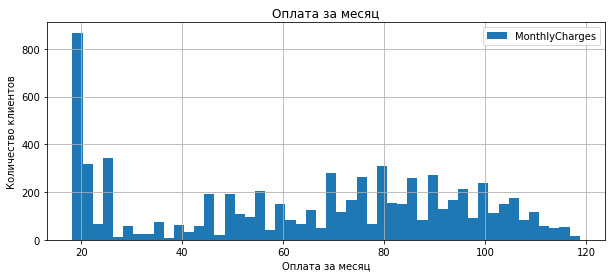

In [17]:
plt.figure(figsize=(10,4))
contract['MonthlyCharges'].plot(kind='hist', bins=50)
plt.legend()
plt.xlabel('Оплата за месяц')
plt.ylabel('Количество клиентов')
plt.title('Оплата за месяц')
plt.grid()
plt.show()

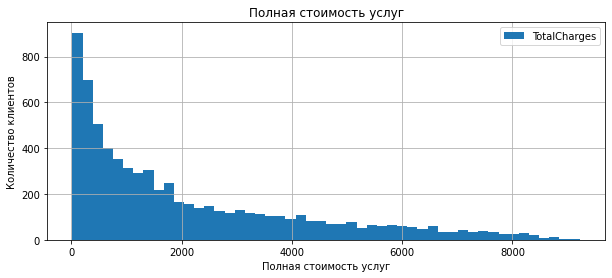

In [18]:
plt.figure(figsize=(10,4))
contract['TotalCharges'].plot(kind='hist', bins=50)
plt.legend()
plt.xlabel('Полная стоимость услуг')
plt.ylabel('Количество клиентов')
plt.title('Полная стоимость услуг')
plt.grid()
plt.show()

Рассмотрим второй файл - `internet_new`  с информацией о подключении к интернету.

In [19]:
internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [20]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


Рассмотрим третий файл - `personal_new`  с информацией о клиентах.

In [21]:
personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [22]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [23]:
personal.Dependents.value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

Рассмотрим четвертый файл - `phone_new`  с информацией о подключении к телефону.

In [24]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [25]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Объединим все таблицы в общий датафрейм

In [26]:
df = contract.join([personal, phone, internet], how='left')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  MultipleLines     6361 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null 

In [28]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [29]:
df = df.fillna('not_used')

Переведем даты в соответствующий формат и посчитаем новый признак - длительность обслуживания.  
Для этого у действующих клиентов из даты заключения контракта будем отнимать дату актуальности данных - 02/01/2020

In [30]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format = '%Y-%m-%d')

In [31]:
df['Duration'] = (pd.to_datetime(df['EndDate'].replace('No', '2020-2-1'), format = '%Y-%m-%d') - df['BeginDate'])
df['Duration'] = (df['Duration'] / np.timedelta64(1, 'D')).astype(int)

Добавим новый признак `is_client`, не забудем убрать дублирующий его оригинал - он нам больше не понадобится  

In [32]:
df['is_client'] = (df['EndDate'] == 'No')*1
df = df.drop(columns='EndDate')

In [33]:
df['is_client'].value_counts()

1    5942
0    1101
Name: is_client, dtype: int64

In [34]:
df.head(2)

,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Duration,is_client
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,not_used,DSL,No,Yes,No,No,No,No,31,1
5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,1036,1


### Исследовательский анализ данных

Визуально ищем на одном графике одинаковые пары столбиков, чтобы заключить, что данный признак не влияет на целевой.  
И находим такую ситуацию - в столбце `gender`  
Значит и мужчины, и женщины разрывают контракты с одинаковой частотой, и сам по себе этот признак модели будет неинтересен.  
Его и `customerID` при обучении можно будет опустить

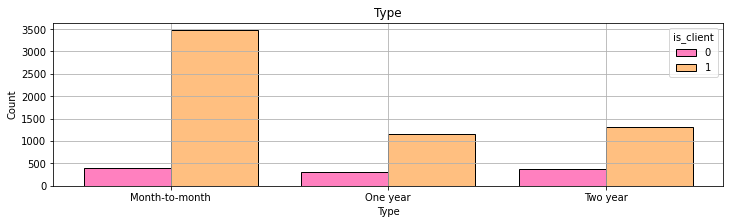

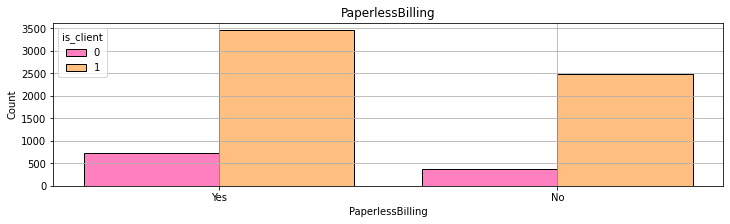

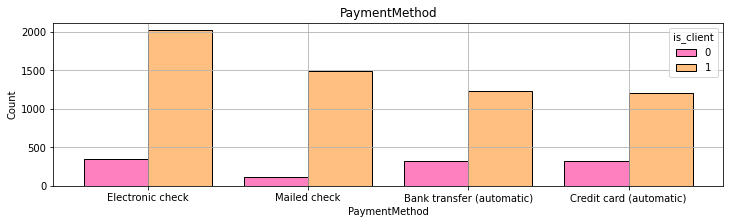

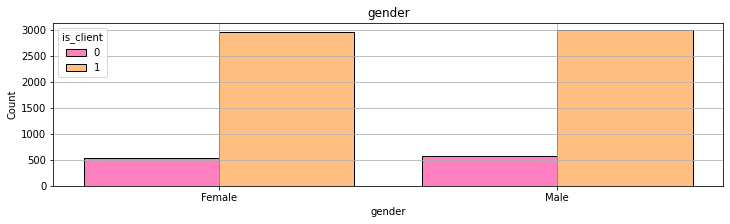

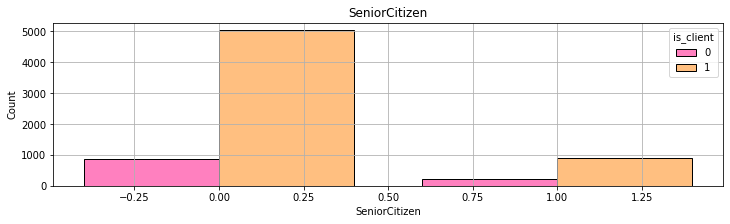

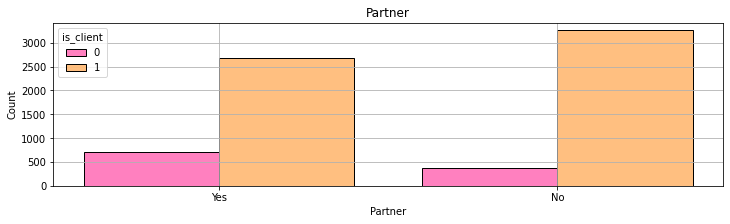

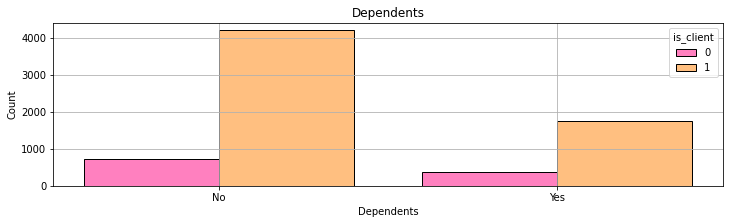

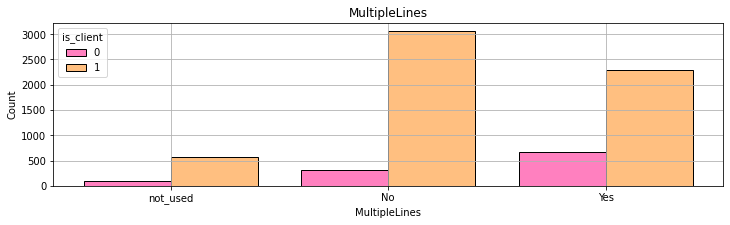

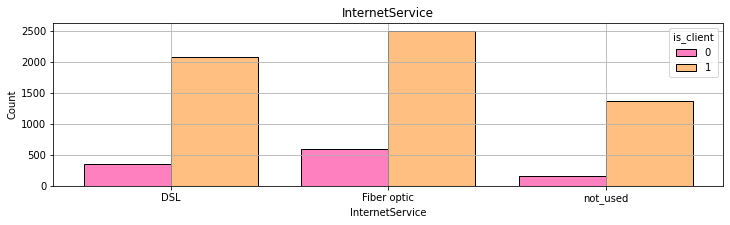

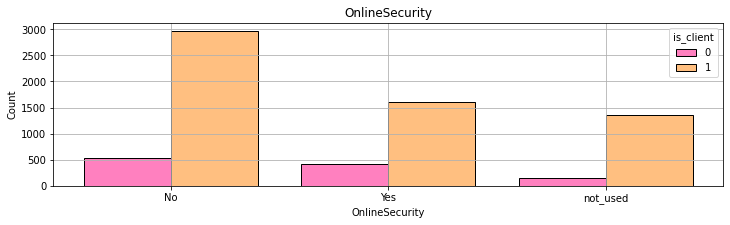

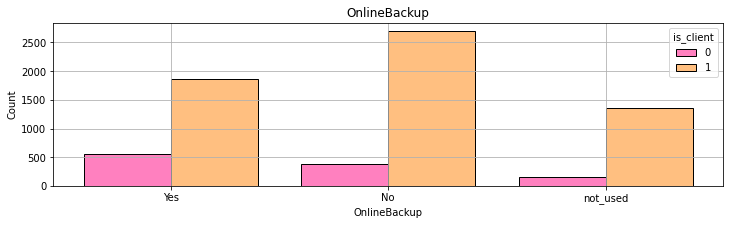

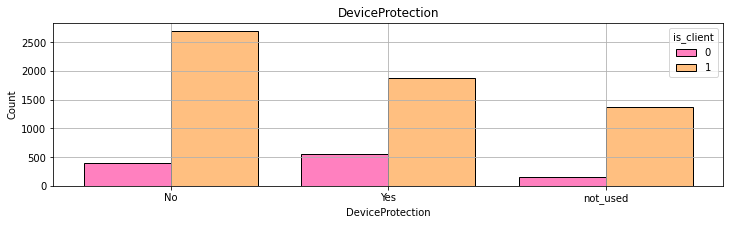

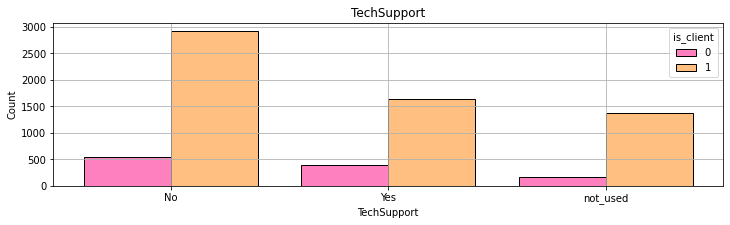

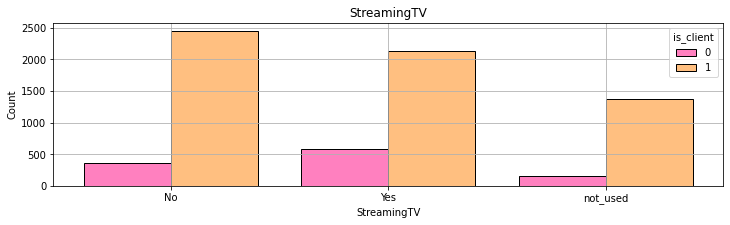

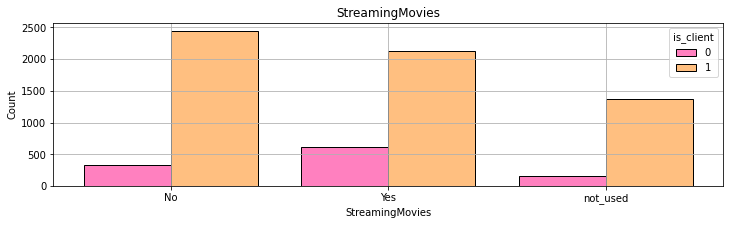

In [35]:
for x in ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner',
          'Dependents', 'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
          'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    plt.figure(figsize=(12,3))
    plt.title(x)
    plt.grid()
    sns.histplot(data = df, x=x, hue=df['is_client'], multiple="dodge", shrink=.8,
                 palette='spring', discrete=True)

Рассмотрим корреляцию признаков.

In [36]:
df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Duration'])

,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Duration,is_client
BeginDate,1.000000,0.766249,0.081447,0.456389,0.421886,0.773659,0.011268,0.050862,0.473514,0.208564,0.468035,0.192197,0.460712,0.496176,0.502422,0.455418,0.419599,0.431137,0.978521,0.450254
Type,0.766249,1.000000,0.106860,0.277462,0.388444,0.468471,0.000000,0.086231,0.179736,0.147680,0.244410,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.634155,0.094015
PaperlessBilling,0.081447,0.106860,1.000000,0.370495,0.467812,0.203144,0.000000,0.242133,0.013218,0.172593,0.099953,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.026799,0.083398
PaymentMethod,0.456389,0.277462,0.370495,1.000000,0.399526,0.335175,0.000000,0.292725,0.243008,0.224903,0.174849,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.350964,0.214832
MonthlyCharges,0.421886,0.388444,0.467812,0.399526,1.000000,0.711029,0.008175,0.304985,0.203545,0.184366,0.709983,0.919002,0.812632,0.818851,0.827272,0.816660,0.864677,0.863616,0.387727,0.226280
TotalCharges,0.773659,0.468471,0.203144,0.335175,0.711029,1.000000,0.000000,0.137707,0.381042,0.082134,0.467339,0.489674,0.516119,0.550225,0.558342,0.527587,0.555337,0.554238,0.847414,0.304287
gender,0.011268,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581
SeniorCitizen,0.050862,0.086231,0.242133,0.292725,0.304985,0.137707,0.000000,1.000000,0.016992,0.324576,0.087925,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.063315,0.086159
Partner,0.473514,0.179736,0.013218,0.243008,0.203545,0.381042,0.000000,0.016992,1.000000,0.652122,0.086249,0.000000,0.091202,0.092012,0.100092,0.076326,0.082251,0.077506,0.453688,0.226688
Dependents,0.208564,0.147680,0.172593,0.224903,0.184366,0.082134,0.000000,0.324576,0.652122,1.000000,0.011198,0.108463,0.117219,0.097766,0.094597,0.109753,0.088193,0.084684,0.198729,0.046871


<AxesSubplot:>

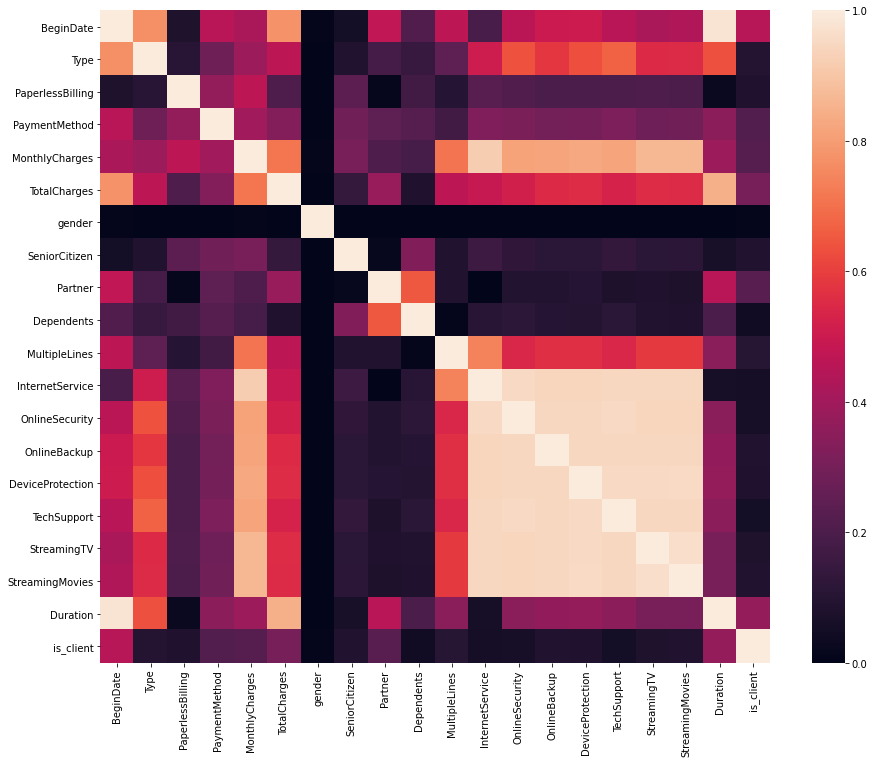

In [37]:
plt.figure(figsize=(15,12))
sns.heatmap(df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Duration']))

Основные коррелирующие с таргетом признаки: `BeginDate`, `Duration`, `TotalCharges`  
Похоже, что у клинта есть в компании своего рода "жизненный цикл", и по статистике спустя определенный промежуток времени клиент с какой-то долей вероятности захочет отказаться от услуг компании   
`gender` подтвердил свою бесполезность "черным крестом"

<AxesSubplot:>

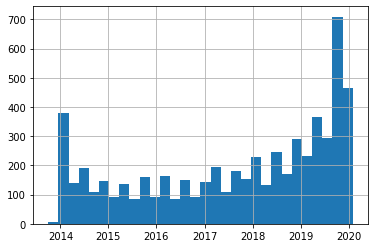

In [38]:
df[df['is_client']==1]['BeginDate'].hist(bins=30)

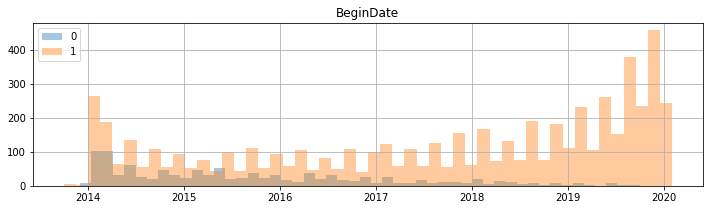

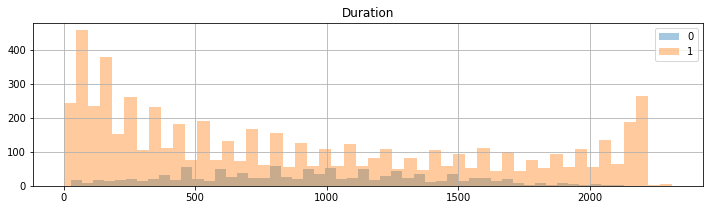

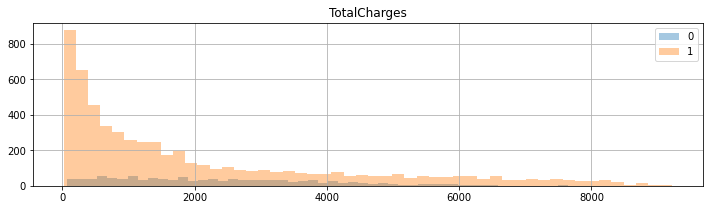

In [39]:
for x in ['BeginDate', 'Duration', 'TotalCharges']:
    plt.figure(figsize=(12,3))
    plt.grid()
    plt.title(x)
    df.groupby('is_client')[x].hist(bins=50, alpha=0.4)
    plt.legend(['0', '1'])
    plt.show()

Получается что большая часть клиентов компании - это старые (до 2015 года) и новые (после 2018). В середине же графиков все "средне"  
Рассмотрим, почему нет второго пика на хвосте последнего графика `TotalCharges`

<AxesSubplot:>

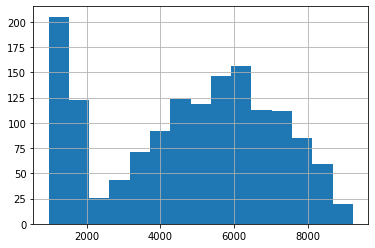

In [40]:
df[(df['is_client']==1)&(df['Duration']>1500)]['TotalCharges'].hist(bins=15)

Все в порядке, старые клиенты нашлись и, похоже, исправно платят.

### Подготовка к обучению

После первого обучения была изучена важность признаков, по итогам решили оставить только самые важные

In [41]:
target = df['is_client']
features = df.drop(columns=['gender', 'is_client', 'BeginDate',
                           'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                           'TechSupport', 'StreamingTV', 'StreamingMovies',
                           'Type', 'PaperlessBilling', 'PaymentMethod',
                           'Partner', 'Dependents', 'SeniorCitizen'],
                   axis=1).reset_index(drop=True)

Посмотрим на корреляцию признаков между собой

<AxesSubplot:>

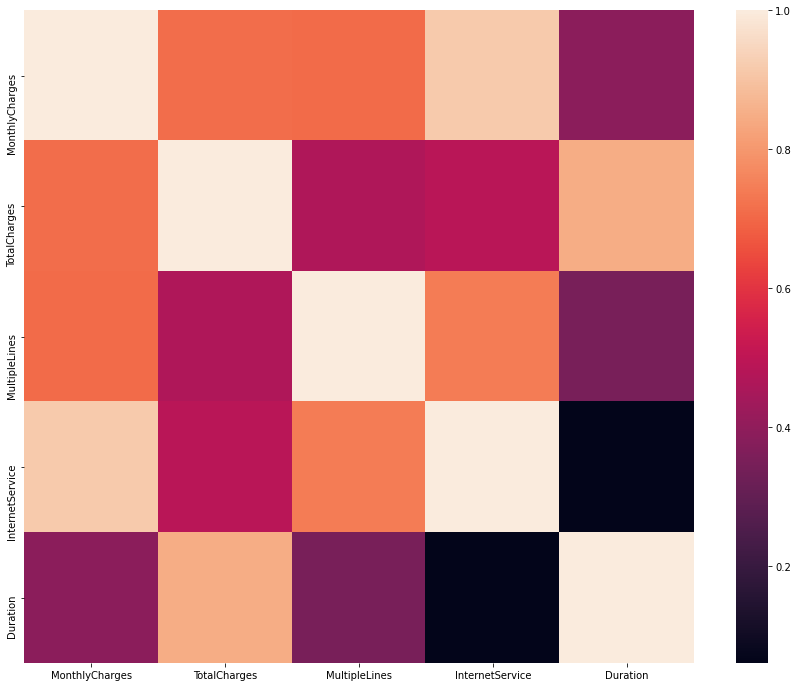

In [42]:
plt.figure(figsize=(15,12))
sns.heatmap(features.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Duration']))

In [43]:
target.value_counts()

1    5942
0    1101
Name: is_client, dtype: int64

In [44]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MonthlyCharges   7043 non-null   float64
 1   TotalCharges     7043 non-null   float64
 2   MultipleLines    7043 non-null   object 
 3   InternetService  7043 non-null   object 
 4   Duration         7043 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 275.2+ KB


In [45]:
features_train, features_test, target_train, target_test = train_test_split(
            features, target, test_size = 0.25, random_state=random_state, stratify=target,
             shuffle=True)

features_train.shape, target_train.shape, features_test.shape, target_test.shape

((5282, 5), (5282,), (1761, 5), (1761,))

In [46]:
#категориальные признаки для OHE
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

#численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
# num_features.remove('SeniorCitizen')
print(num_features)

['MultipleLines', 'InternetService']
['MonthlyCharges', 'TotalCharges', 'Duration']


In [47]:
encoder_ohe = OneHotEncoder(drop='first', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)

/tmp/ipykernel_264/36959420.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [48]:
features_test[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(features_test[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_test = features_test.drop(ohe_features, axis=1)

/tmp/ipykernel_264/4273399300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [49]:
# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

# смотрим на результат
features_train.head()

,MonthlyCharges,TotalCharges,Duration,x0_Yes,x0_not_used,x1_Fiber optic,x1_not_used
5237,-0.324813,-0.319019,-0.143956,0.0,0.0,0.0,0.0
6425,-0.674145,-0.134022,0.524537,0.0,1.0,0.0,0.0
2928,1.017621,2.374846,1.735171,0.0,0.0,1.0,0.0
634,-0.331467,0.040085,0.481930,0.0,1.0,0.0,0.0
2378,0.192531,0.205221,0.301217,0.0,0.0,1.0,0.0


In [50]:
features_train.shape

(5282, 7)

### Обучение моделей

In [52]:
model_LR = LogisticRegression(random_state=random_state, solver='liblinear', class_weight='balanced')
grid={"C":[0.1, 1, 10, 100], "penalty":["l1","l2"]}
lr_cv=GridSearchCV(model_LR, grid, cv=10)
lr_cv.fit(features_train,target_train)
res_lr = cross_val_score(lr_cv, features_train, target_train, cv=5, scoring='roc_auc')
print(res_lr)

[0.69339584 0.67386042 0.70688705 0.7392579  0.70926096]


In [53]:
lr_cv.best_params_

{'C': 10, 'penalty': 'l1'}

In [54]:
rf = RandomForestClassifier()

param_grid = [
    {
     'class_weight' : ['balanced'],
     'max_depth' : list(range(3,13,3)),
    'n_estimators' : list(range(100,201,50)),
    'random_state' : list([random_state])}
]

clf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose=True,
                   n_jobs=-1, scoring='roc_auc')

best_clf = clf.fit(features_train, target_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [55]:
print(f'best_score: {best_clf.best_score_}')
print(best_clf.best_params_)

best_score: 0.7818230269440217
{'classifier': RandomForestClassifier(class_weight='balanced', max_depth=6,
                       random_state=280823), 'classifier__class_weight': 'balanced', 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__random_state': 280823}


In [57]:
# Initialize CatBoostClassifier
cb = CatBoostClassifier(  verbose=False,
                        random_seed=random_state)

param_grid = {'learning_rate': list(np.arange(0.2, 0.41, 0.1)),
            'depth': list(range(2,5,1)),
            'iterations' : list(range(200,601,200))}

cb = GridSearchCV(cb, param_grid,
                  scoring='roc_auc',
                  cv=3,
                  refit=True,
                  verbose=False)

cb.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f1adba9cd60>,
             param_grid={'depth': [2, 3, 4], 'iterations': [200, 400, 600],
                         'learning_rate': [0.2, 0.30000000000000004,
                                           0.4000000000000001]},
             scoring='roc_auc', verbose=False)

In [58]:
cb.best_score_

0.8967770496138016

In [59]:
cb.best_params_

{'depth': 2, 'iterations': 600, 'learning_rate': 0.30000000000000004}

Лучшие параметры из рассмотренных моделей у Catboost - 0,89 на обучении

### Тестирование лучшей модели. Catboost

In [60]:
proba = cb.predict_proba(features_test)[:,1]
print('Значение AUC-ROC модели:', roc_auc_score(target_test, proba))

Значение AUC-ROC модели: 0.9289783433255843


In [61]:
preds = cb.predict(features_test)
print('Значение accuracy_score модели:', accuracy_score(target_test, preds))

Значение accuracy_score модели: 0.9477569562748438


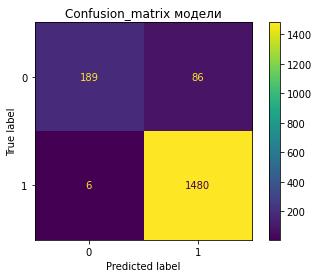

In [62]:
conf_matrix = confusion_matrix(target_test, preds)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cb.classes_)
vis.plot()
plt.title('Сonfusion_matrix модели')
plt.show()

Матрица ошибок:  
189 ушедших клиентов успешно обнаружены  
86 не найдены  
И только 6 действующих клиентов помечены как ушедшие  

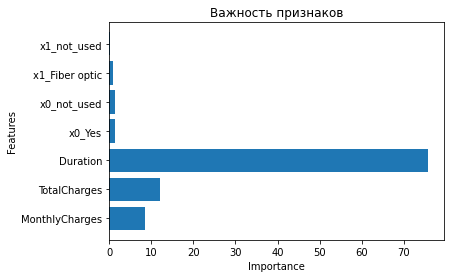

In [63]:
plt.barh(features_train.columns, cb.best_estimator_.feature_importances_)
plt.title('Важность признаков')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show;

График важности признаков, показал, что самым важным для модели был признак `Duration`, посчитанный нами из даты заключения и расторжения контракта.

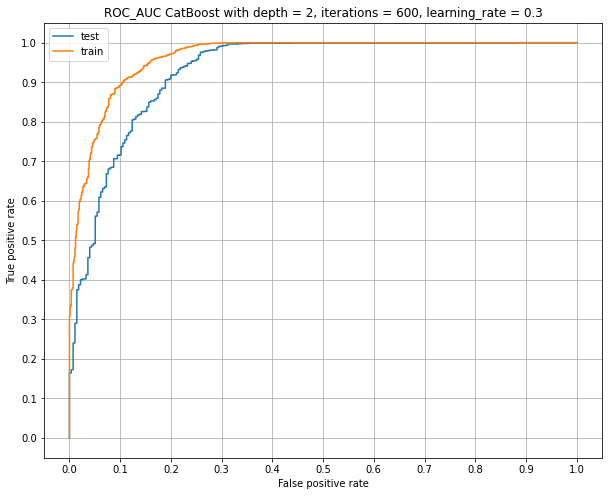

In [64]:
train_predicted = cb.predict_proba(features_train)[:, 1]
test_predicted = cb.predict_proba(features_test)[:, 1]
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(*roc_curve(target_test, test_predicted)[:2], label='test')
ax.plot(*roc_curve(target_train, train_predicted)[:2], label='train')
ax.legend()
ax.set(xlabel='False positive rate', ylabel='True positive rate',
       title='ROC_AUC CatBoost with depth = 2, iterations = 600, learning_rate = 0.3')
ax.grid()
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(np.linspace(0, 1, 11));

### Вывод

В ходе исследования были проведены следующие этапы:
- Предобработка данных (заполнение пропусков, объединение таблиц)
- Исследовательский анализ (поиск взаимосвязей в признаках, изучение распределений)
- Подготовка данных к обучению (удаление лишних стобцов, разделение на выборки, кодирование, масштабирование)
- Обучение моделей (LogisticRegression, RandomForest, Catboost), подбор гиперпараметров, кросс-валидация
- Тестирование лучшей модели и изучение ее параметров

Лучшие характеристики показала модель **Catboost**:
- Значение roc-auc модели: 0.93
- Значение accuracy_score модели: 0.95

Параметры модели:
> iterations=600,  
learning_rate=0.3,  
depth=2,  
random_seed=280823

Матрица ошибок показала, что 189 ушедших клиентов успешно обнаружены  
86 не найдены  
И только 6 действующих клиентов помечены как ушедшие.  
Можно с большой долей вероятности заключить, что практически каждый, кого модель пометит как "уходящего" клиента, в действительности окажется таковым


### Отчет

В ходе исследования были пройдены все этапы согласно плану:
> 1. Предобработка данных (заполнение пропусков, объединение таблиц)  
2. Исследовательский анализ (поиск взаимосвязей в признаках, изучение распределений)  
3. Подготовка данных к обучению (удаление лишних стобцов, разделение на выборки, кодирование, масштабирование)  
4. Обучение моделей (LogisticRegression, RandomForest, Catboost), подбор гиперпараметров, кросс-валидация  
5. Тестирование лучшей модели и изучение ее параметров  
6. Вывод, включающий:  
  * Параметр ROC-AUC для выбранной модели  
  * Параметр accuracy  
  * Confusion matrix  


Ключевые шаги выполнения проекта:
* Изучение данных, предобработка
* Отбор нужных признаков
* Подбор гиперпараметров модели


В итоге наилучшие результаты показала модель, обученная на признаках:
>MonthlyCharges (масштабирование)  
TotalCharges (масштабирование)      
MultipleLines (кодирование)      
InternetService (кодирование)   
Duration (масштабирование)   


Лучшие характеристики показала модель **Catboost**:
- Значение roc-auc модели: 0.93
- Значение accuracy_score модели: 0.95


Параметры модели:
> iterations=600,  
learning_rate=0.3,  
depth=2,  
random_seed=280823

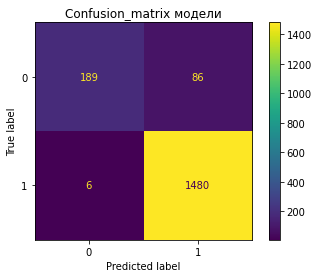
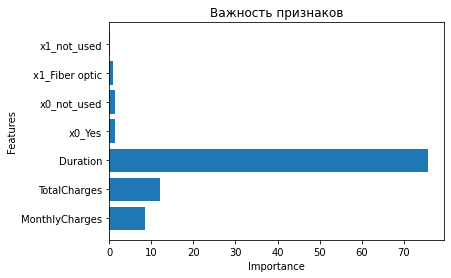
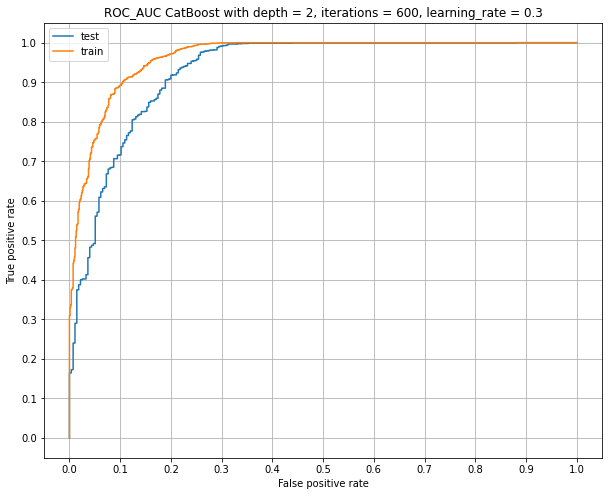